In [1]:
import sys

sys.path.append("../")

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

# DATA_PATH = '/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min'
DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/1h'

In [3]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTC', 'ETH', 'ADA', 'BNB', 'SOL', 'XRP', 'DOGE', 'DOT', 'LUNA', 'UNI', 'LINK', 'BCH', 'LTC', 'ALGO', 'AVAX', 'ICP', 'WBTC', 'FTT', 'MATIC', 'FIL', 'XLM', 'VET', 'ETC', 'TRX', 'THETA']
symbols = [f'{s}-USDT' for s in symbols]

data = []
start_date = '2021-05-01'
end_date = '2021-08-01'

for symbol in symbols:
    try:
        file = f'{DATA_PATH}/{symbol}.csv'
        # print(file)
        df = pd.read_csv(file, 
                        parse_dates=['open_time'], 
                        index_col=['open_time'])
        df = df[(df.index > start_date) & (df.index < end_date)]
        df = df[~df.index.duplicated(keep='first')]

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(np.log(df[symbol]))
    except:
        pass

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
df.dropna(inplace=True, how='any')

df.tail()

,BTC-USDT,ETH-USDT,ADA-USDT,BNB-USDT,SOL-USDT,XRP-USDT,DOGE-USDT,DOT-USDT,LUNA-USDT,UNI-USDT,...,LTC-USDT,ALGO-USDT,AVAX-USDT,MATIC-USDT,FIL-USDT,XLM-USDT,VET-USDT,ETC-USDT,TRX-USDT,THETA-USDT
open_time,,,,,,,,,,,,,,,,,,,,,
2021-07-31 19:00:00,10.628536,7.806232,0.263825,5.801695,3.537998,-0.292092,-1.574795,2.798256,2.375836,3.051687,...,4.962495,-0.179845,2.556297,0.044782,3.940358,-1.258922,-2.435088,3.921676,-2.752629,1.804840
2021-07-31 20:00:00,10.633541,7.820323,0.268576,5.807181,3.550307,-0.288216,-1.570073,2.814630,2.389313,3.066657,...,4.968076,-0.170551,2.581050,0.050598,3.945303,-1.251169,-2.431101,3.932923,-2.747155,1.810908
2021-07-31 21:00:00,10.644234,7.838671,0.278389,5.821714,3.585212,-0.279185,-1.562077,2.832154,2.391603,3.084933,...,4.980726,-0.165111,2.592041,0.062693,3.951993,-1.244830,-2.411954,3.946618,-2.739851,1.814662
2021-07-31 22:00:00,10.641694,7.838237,0.279751,5.823016,3.587954,-0.283159,-1.563413,2.829796,2.389221,3.086532,...,4.980726,-0.162754,2.605205,0.083973,3.960261,-1.242887,-2.408612,3.944393,-2.739541,1.805662
2021-07-31 23:00:00,10.632198,7.836168,0.276798,5.806640,3.603349,-0.292494,-1.571612,2.819353,2.373975,3.078740,...,4.972310,-0.174949,2.606682,0.080012,3.951840,-1.256600,-2.411062,3.938840,-2.749341,1.808944


In [4]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
    # print("trace_crit_value",trace_crit_value)
    # print("eigen_crit_value",eigen_crit_value)
    # print("lr1",result.lr1)
    # print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [5]:

import itertools as it

nb_symbols = 3
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except KeyError:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2,sid_3
0,"[16.241170948544408, -20.225802335647366, 11.3...",BTC-USDT,ETH-USDT,ADA-USDT
1,"[11.34193773230827, -4.89148000921201, -3.8617...",BTC-USDT,ETH-USDT,SOL-USDT
2,"[10.033921067268292, -9.862664713714825, 2.445...",BTC-USDT,ETH-USDT,XRP-USDT
3,"[3.606269829346083, -13.996900801637436, 4.995...",BTC-USDT,ETH-USDT,DOT-USDT
4,"[10.552499456447187, -2.3612077717285995, -1.8...",BTC-USDT,ETH-USDT,LINK-USDT


In [6]:
coint_df.to_csv('coint_df.csv')


In [7]:
def calculate_spread(selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        selected_row = i
        hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
        spread = calculate_spread(selected_row, hedge_ratio)
        adf_p = adf_test(spread, verbose=False)
        pp_p = pp_test(spread, verbose=False)
        kpss_p = kpss_test(spread, verbose=False)

        if adf_p < critical_val and pp_p < critical_val and kpss_p > critical_val:
            half_life = cal_half_life(spread)
            pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[selected_row].values
            # print(i, pairs_name, 'is stationary with half life', half_life)
            # print(' ')
            data.append({
                'i': i,
                'pairs': pairs_name,
                'half_life': half_life
            })
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio()
stationary_df.sort_values(by=['half_life'], inplace=True)
stationary_df

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: Interpolat

,i,pairs,half_life
109,164,"[BCH-USDT, LTC-USDT, ETC-USDT]",10
57,99,"[BNB-USDT, BCH-USDT, LTC-USDT]",12
107,162,"[BCH-USDT, LTC-USDT, FIL-USDT]",12
39,78,"[ADA-USDT, BCH-USDT, LTC-USDT]",13
13,26,"[BTC-USDT, BCH-USDT, LTC-USDT]",13
...,...,...,...
1,2,"[BTC-USDT, ETH-USDT, XRP-USDT]",99
24,61,"[ADA-USDT, BNB-USDT, ETC-USDT]",106
4,9,"[BTC-USDT, ETH-USDT, XLM-USDT]",117
5,10,"[BTC-USDT, ETH-USDT, THETA-USDT]",128


In [8]:
selected_row = stationary_df['i'].iloc[0]
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
spread = calculate_spread(selected_row, hedge_ratio)

In [12]:
hedge_ratio

array([ 31.9487221 , -28.90781725,  -5.57187024])

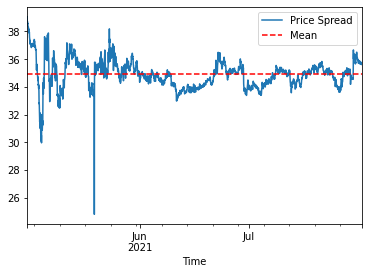

In [9]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [10]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

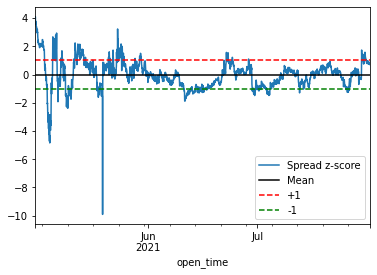

In [11]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])